# Traffic Sign Detection and Classification
This work focuses on the detection of color and shapes regarding traffic signs under many different circumstances and combinations of illumination, angle, and contrast.

The first step is to import all the necessaries libraries that will be used in this project.

In [620]:
import cv2
import os

import xml.etree.ElementTree as ET
import imutils
import numpy as np
import math

### Global Variables
- `FILENAME`: Define the road or parse all roads inside the `data` folder. `ALL` to show all images.
- `TYPE`: `WINDOW` to open an window with the image, `FILE` to create a file with the file.  
- `Debug`: Used for testing purposes.

In [621]:
FILENAME = "ALL"
OUTPUT = "WINDOW"
DEBUG = False

### Image Data

Class used to store information about the image.














In [622]:
class Data:
    def __init__(self, filename) -> None:
        self.filename = filename
        self.image = cv2.imread(filename)


In [623]:
def matching_stop(img1, img2):

    MIN_MATCH_COUNT = 5

    img1 = cv2.imread(img1,cv2.IMREAD_GRAYSCALE) # queryImage
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    img1 = cv2.GaussianBlur(img1, (5, 5), 0)
    img2 = cv2.GaussianBlur(img2, (5, 5), 0)

    # Initiate SIFT detector
    sift = cv2.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()

        h,w = img1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)

        img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

    else:
        #print("Not enough matches are found - " + str(len(good)) + "/" + str(MIN_MATCH_COUNT))
        matchesMask = None
        return

    print(good)
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                       singlePointColor = None,
                       matchesMask = matchesMask, # draw only inliers
                       flags = 2)
    
    list_kp2 = [kp2[mat.trainIdx].pt for mat in good]
    x,y = sum(i for i, j in list_kp2), sum(j for i, j in list_kp2)
    x_mean = int(x/len(good))
    y_mean = int(y/len(good))
    
    cv2.putText(img2, "sign", (x_mean,y_mean), cv2.FONT_HERSHEY_SIMPLEX,0.5, (255, 255, 255), 2)
    
    img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

    plt.imshow(img3, 'gray'),plt.show()

    cv2.imshow("Image", img2)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    

### Shape detection class

This class is used to detect the Shape present in the image

In [624]:
class ShapeDetector:
    def __init__(self, red, blue, image) -> None:
        self.red = red
        self.blue = blue
        self.image = image

    def _shape_name(self, contour, colour):
        peri = cv2.arcLength(contour, True)
        factor = 0.02 if colour == "blue" else 0.01
        approx = cv2.approxPolyDP(contour, factor * peri, True) # Estava 0.01, verificar tudo de novo a ver se não estraga...            

        if len(approx) == 3:
            return "triangle"
        elif len(approx) == 4:
            (_, _, width, height) = cv2.boundingRect(approx)
            aspect_ratio = width / float(height)

            # a square will have an aspect ratio that is approximately equal to one, otherwise, the shape is a rectangle
            return "square" if 0.90 <= aspect_ratio <= 1.10 else "rectangle"
        elif 6 <= len(approx) <= 7:
            # if the shape is a triangle, it will have can have 6 or 7 vertices (due to the corner curves)
            distances = []
            for x,y in zip(approx, approx[1:]):
                d = math.sqrt((x[0][1]-y[0][1])*(x[0][1]-y[0][1]) + (x[0][0]-y[0][0])*(x[0][0]-y[0][0]))
                distances.append(d)

            distances.sort()
            if distances[len(approx) - 5] < 1/4 * distances[len(approx) - 4] or distances[len(approx) - 4] < 1/4 * distances[len(approx) - 3]:
                return  "triangle"
        elif len(approx) == 8 and colour == "red":
            return  "stop"

        print(len(approx))
        return "unidentified"

    def _shape_countours(self, image, colour):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
        blurred = cv2.GaussianBlur(gray, (7, 7), 0)
        blurred = cv2.threshold(blurred, 20, 255, cv2.THRESH_BINARY)[1]

        # cv2.imshow('THRESGOL', blurred)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

        final_contours = []

        # find contours in the thresholded image and initialize the shape detector
        countours = cv2.findContours(blurred.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        countours = imutils.grab_contours(countours)

        # Draw circles
        # TODO: Verify better values
         # param1 estava a 100, mudamos por causa do road53.png, mudamos param2 de 0.8 para 0.5
        circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT_ALT, 1.5, 30, param1=250, param2=0.75, minRadius=1)

        if circles is None: circles = [[]]
        circles = np.uint16(np.around(circles))

        processed_centers = {}
        for i in circles[0,:]:
            if (i[0],i[1]) in processed_centers.keys():
                if processed_centers[(i[0],i[1])] < i[2]:
                    processed_centers[(i[0],i[1])] = i[2]
            else:
                processed_centers[(i[0], i[1])] = i[2]

        for c in countours:
            # TODO: Area?
            # Area of the Image
            # AREA = img.shape[0]*img.shape[1]/20
            AREA = 1000
            if cv2.contourArea(c) < AREA:
                continue
            
            # Shape of the Image
            shape = self._shape_name(c, colour)
            if shape == "unidentified":
                continue

            # Compute the center of the contour, then detect the name of the shape using only the contour
            M = cv2.moments(c)
            cX = int((M["m10"] / (M["m00"] + 1e-7))) #* ratio)
            cY = int((M["m01"] / (M["m00"] + 1e-7))) #* ratio)
            
            # TODO: Ratio?
            # multiply the contour (x, y)-coordinates by the resize ratio, then draw the contours and the name of the shape on the image
            c = c.astype("float")
            # c *= ratio
            c = c.astype("int")
            
            # TODO: If the building is red still detects a stop sign - road78.png
            # if not contains_circle:
            if not (shape == "stop" and colour == "blue"): 
                final_contours.append((shape, c, colour))

                # Draw and write shape name
                cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
                classification = f"{colour} {shape}" if shape != "stop" else "stop sign"
                cv2.putText(image, classification, (cX - 35, cY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)


        for (i[0],i[1]) in list(processed_centers.keys()):
            circle = {'center': (i[0],i[1]), 'radius': (processed_centers[i[0],i[1]])}
            final_contours.append(("circle", circle, colour))

            # Draw the circle, center and write the shape name
            cv2.circle(image,(i[0],i[1]),processed_centers[i[0],i[1]],(0,255,0),2)
            cv2.circle(image,(i[0],i[1]),2,(0,0,255),3)
            classification = f"{colour} circle"
            cv2.putText(image, classification, (i[0] - 35, i[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        return final_contours

    def find_shape(self):
        red_contours = self._shape_countours(self.red, "red")
        blue_contours = self._shape_countours(self.blue, "blue")

        return red_contours + blue_contours


### Color Detection Class

Used to detect the color of the image

In [625]:
class ColorDetector:
    def __init__(self, image) -> None:
        self.image = image

    def find_color(self):
        hsv = cv2.cvtColor(self.image, cv2.COLOR_BGR2HSV)

        h,s,v = cv2.split(hsv)
        hue = hsv[:, :, 0].mean()
        saturation = hsv[:, :, 1].mean()

        # CLAHE: used to increase contrast
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        swithCLAHE = clahe.apply(s)
        vwithCLAHE = clahe.apply(v)

        hsv = cv2.merge([h, swithCLAHE, vwithCLAHE])

        # Generate lower mask (0-10) and upper mask (170-180) of red
        if saturation < 61:
            if hue < 70:
                red_mask1 = cv2.inRange(hsv, (0,90,50), (20,255,255)) # deteta tudo no road56.png
                red_mask2 = cv2.inRange(hsv, (160,90,50), (180,255,255)) # deteta tudo no road56.png
            else:
                red_mask1 = cv2.inRange(hsv, (0,90,50), (10,255,255)) # deteta tudo no road56.png
                red_mask2 = cv2.inRange(hsv, (170,90,50), (180,255,255)) # deteta tudo no road56.png
        else:
            if hue < 70:
                red_mask1 = cv2.inRange(hsv, (0,30,30), (20,255,255)) # deteta tudo no road66.png
                red_mask2 = cv2.inRange(hsv, (160,30,30), (180,255,255)) # deteta tudo no road66.png
            else:
                red_mask1 = cv2.inRange(hsv, (0,30,30), (10,255,255)) # deteta tudo no road66.png
                red_mask2 = cv2.inRange(hsv, (170,30,30), (180,255,255)) # deteta tudo no road66.png

            # red_mask1 = cv2.inRange(hsv, (0,65,30), (20,255,255)) # deteta tudo no road57.png
            # red_mask2 = cv2.inRange(hsv, (160,65,30), (180,255,255)) # deteta tudo no road57.png
            # red_mask1 = cv2.inRange(hsv, (0,30,30), (20,255,255)) # deteta tudo no road66.png
            # red_mask2 = cv2.inRange(hsv, (160,30,30), (180,255,255)) # deteta tudo no road66.png

        # Merge the mask and crop the red regions
        red_mask = cv2.bitwise_or(red_mask1, red_mask2)

        # Generate mask (100-140) of blue
        if saturation < 40:
            blue_mask = cv2.inRange(hsv, (100,130,50), (140,255,255))
        else:
            blue_mask = cv2.inRange(hsv, (100,220,50), (140,255,255))

        print("saturacao" + str(saturation))
        print("hue" + str(hue))
        red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, np.ones((3,3),np.uint8))
        # red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_DILATE, np.ones((3,3),np.uint8))

        blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_OPEN, np.ones((3,3),np.uint8))
        blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_DILATE, np.ones((3,3),np.uint8))

        red = cv2.bitwise_and(self.image, self.image, mask=red_mask)
        blue = cv2.bitwise_and(self.image, self.image, mask=blue_mask)

        red_hsv = cv2.cvtColor(red, cv2.COLOR_BGR2HSV)
        average_hsv_1 = cv2.mean(red_hsv, red_mask1)[:3]
        average_hsv_2 = cv2.mean(red_hsv, red_mask2)[:3] 
        average_hsv_red = cv2.mean(red_hsv,  red_mask)[:3]

        blue_hsv = cv2.cvtColor(blue, cv2.COLOR_BGR2HSV)
        average_hsv_blue = cv2.mean(blue_hsv,  blue_mask)[:3]

        min_value_saturation_red = red_hsv[np.where(red_hsv[:,:,1]>0)][:,1].min() if red_hsv.any() else 100
        min_value_saturation_blue = blue_hsv[np.where(blue_hsv[:,:,1]>0)][:,1].min() if blue_hsv.any() else 100

        red_threshold = (average_hsv_red[1] + min_value_saturation_red) / 2
        blue_threshold = (average_hsv_blue[1] + min_value_saturation_blue) / 2

        print("thresohold azul" + str(blue_threshold))
        # blue_threshold = 200

        max_red1 = 10 if average_hsv_1[0] <= 15 else 20
        min_red2 = 170 if average_hsv_2[0] > 175 else 160 # TODO: devia ser average_hsv_2, mudar para verificar se não estraga

        red_mask1 = cv2.inRange(hsv, (0, red_threshold, 50), (max_red1, 255, 255))
        red_mask2 = cv2.inRange(hsv, (min_red2, red_threshold, 50), (180, 255, 255))
        
        blue_mask = cv2.inRange(hsv, (90, blue_threshold, 50), (130, 255, 255))

        # Merge the mask and crop the red regions
        red_mask = cv2.bitwise_or(red_mask1, red_mask2)
        red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, np.ones((3,3),np.uint8))

        blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_OPEN, np.ones((3,3),np.uint8))
        blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_DILATE, np.ones((3,3),np.uint8))

        red = cv2.bitwise_and(self.image, self.image, mask=red_mask)
        blue = cv2.bitwise_and(self.image, self.image, mask=blue_mask)

        # Show red tracing
        if DEBUG:
            cv2.imshow('Red Color', red)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

        # Show blue tracing
        if DEBUG:
            cv2.imshow('Blue Color', blue)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

        mask = cv2.bitwise_or(red, blue)
        result = cv2.bitwise_and(self.image, mask)

        # Show blue and red tracing
        if DEBUG:
            cv2.imshow('Red Color Detection', red)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
        return ("gray", red, blue, result)

for i in range(52,100):
    matching_stop("stop.png","road"+str(i)+".png")

### Image Evaluation

Function to evaluate the image

In [626]:
def evaluate_image(image_data):
    color_detector = ColorDetector(image_data.image)
    image_color, red_result, blue_result, color_result = color_detector.find_color()

    shape_detector = ShapeDetector(red_result, blue_result, color_result)
    contours = shape_detector.find_shape()

    processed_contours = []
    for t, c, colour in contours:
        if t == "circle":
            center = (c['center'][0], c['center'][1])
        else:
            M = cv2.moments(c)
            cX = int((M["m10"] / (M["m00"] + 1e-7))) #* ratio)
            cY = int((M["m01"] / (M["m00"] + 1e-7))) #* ratio)
            center = (cX, cY)

        contour_radius = c['radius'] if t == "circle" else cv2.minEnclosingCircle(c)[1]
        if not processed_contours:
            processed_contours.append((t, c, colour))
            continue

        invalid_contours = []
        append_contour = False
        processed_verified = 0
        
        #print(f'LEN PROCESSED:::: {len(processed_contours)}')

        for (tp, cp, colourp) in processed_contours:
            #print('PROCESSED')
            #print(f'TYPE {tp}, colour {colourp}')

            circle_inside = False
            dist = 0
            processed_contour_radius = cp['radius'] if tp == "circle" else cv2.minEnclosingCircle(cp)[1]

            if tp == "circle":
                #print(f'processed_contour_radius: {processed_contour_radius}')
                #print(f'center do processed: {int(cp["center"][0]), int(cp["center"][1])}')
                #print(f'center do contorno: {int(center[0]), int(center[1])}')
                #print(f'quadrado 1: {(int(cp["center"][0]) - int(center[0]))**2}')
                #print(f'quadrado 2: {(int(cp["center"][1]) - int(center[1]))**2}')
                #print(f'quadrado 3: {int(processed_contour_radius)**2}')
                if (int(cp['center'][0]) - int(center[0]))**2 + (int(cp['center'][1]) - int(center[1]))**2 < processed_contour_radius**2: # check if center of circle is inside the contour
                    circle_inside = True
            else:
                dist = cv2.pointPolygonTest(cp, center, True)
            if dist > 0 or circle_inside: # center of the contour is inside a processed contour
                #print(f'PRIMEIRA CONDIÇAO {(contour_radius >= 2/3 * processed_contour_radius and ((colourp == "red" and t == "stop") or (colour == "red" and tp != "stop")))}')
                #print(f'SEGUNDA CONDIÇAO {(contour_radius >= processed_contour_radius and colour != "blue")}')
                if (contour_radius >= 2/3 * processed_contour_radius and colour == "red" and not (t == "stop" or tp == "stop")) or (contour_radius >= processed_contour_radius and colour != "blue"): # the radius of the contour is bigger than the radius of the processed contour
                    invalid_contours.append((tp, cp, colourp))
                    append_contour = True
            else:
                processed_verified += 1


        for i in invalid_contours:
            processed_contours.remove(i)
        if append_contour or (processed_verified == len(processed_contours)):
            processed_contours.append((t, c, colour))



    signs = []
    stop_count = 0
    for t, c, colour in processed_contours:
        signs.append(t)
        if t == "circle":
            cv2.circle(image_data.image,(c['center']),c['radius'],(0,255,0),2) # draw the outer circle
            cv2.circle(image_data.image,(c['center']),2,(0,0,255),3) # draw the center of the circle
            cv2.putText(image_data.image, f"{colour} circle", (c['center'][0] - 35, c['center'][1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2) # write the shape
        else:
            if t == "stop": stop_count += 1
            M = cv2.moments(c)
            cX = int((M["m10"] / (M["m00"] + 1e-7))) #* ratio)
            cY = int((M["m01"] / (M["m00"] + 1e-7))) #* ratio)
            cv2.drawContours(image_data.image, [c], -1, (0, 255, 0), 2)
            classification = f"{colour} {t}" if t != "stop" else "stop sign"
            cv2.putText(image_data.image, classification, (cX - 35, cY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
        
    if stop_count == 0:
        stop_sign = os.path.join("./data", "stop.png")
        matching_stop(stop_sign, image_data.image)

    return signs, image_data


Finally, we will run our code, processing the request images.

- Press any key to see the next image, if any
- 
- Press the key `Esc` to exit the application

saturacao60.80605172413793
hue28.472922413793103
thresohold azul50.0
------
['stop', 'circle', 'circle']
['stop']
print53
saturacao59.31404166666667
hue74.20561666666667
thresohold azul50.0
18
7
------
['stop', 'circle']
['stop']
print54
saturacao65.93465355805243
hue64.5320786516854
thresohold azul50.0
12
8
[<DMatch 0000020FD6CCDE10>, <DMatch 0000020FD6CCDFD0>, <DMatch 0000020FD6CCDED0>, <DMatch 0000020FD6CCE790>, <DMatch 0000020FD6CCE8F0>, <DMatch 0000020FD6CCE710>, <DMatch 0000020FD6CCE810>, <DMatch 0000020FD6CCE770>, <DMatch 0000020FD6CCEEB0>]


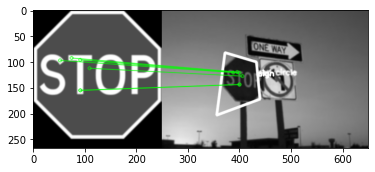

------
['circle']
['stop']
print55
saturacao48.391725
hue22.82315
thresohold azul50.0
------
['stop', 'circle', 'circle']
['stop']
print56
saturacao118.353775
hue42.57380833333333
thresohold azul50.0
6
8
8
------
['stop']
['stop']
print57
saturacao107.33051495016612
hue52.91627906976744
thresohold azul50.0
------
['stop']
['stop']
print58
saturacao138.8392441860465
hue39.620531561461796
thresohold azul50.0
------
['stop']
['stop']
print59
saturacao123.96198125
hue31.80425
thresohold azul50.0
------
['stop']
['stop']
print60
saturacao66.52696013289037
hue122.69143687707641
thresohold azul50.0
6
9
9
9
------
['stop', 'circle']
['stop']
print61
saturacao51.512022471910115
hue76.58051498127341
thresohold azul50.0
7
------
['stop']
['stop']
print62
saturacao88.3437707641196
hue41.856029900332224
thresohold azul50.0
16
9
[<DMatch 0000020FD6CCE090>, <DMatch 0000020FD6CCDFB0>, <DMatch 0000020FD6CCDE70>, <DMatch 0000020FD6CCECB0>, <DMatch 0000020FD6CCED90>, <DMatch 0000020FD6CCF070>]


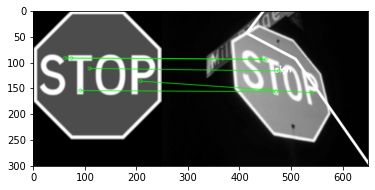

------
[]
['stop']
print63
saturacao170.05369601328903
hue134.7611877076412
thresohold azul50.0
------
['stop']
['stop']
print64
saturacao36.24289179104478
hue47.09916044776119
thresohold azul50.0
15
16
12
11
------
['stop', 'circle', 'circle']
['stop']
print65
saturacao62.78265780730897
hue94.3297342192691
thresohold azul50.0
10
7
8
13
11
------
['circle', 'circle', 'circle', 'circle']
['stop']
print66
saturacao66.69875
hue38.83299074074074
thresohold azul50.0
14
10
6
7
------
['stop']
['stop']
print67
saturacao91.22105833333333
hue72.580675
thresohold azul50.0
17
14
14
9
------
['stop']
['stop']
print68
saturacao79.18509966777408
hue112.70538205980067
thresohold azul50.0
9
------
['stop']
['stop']
print69
saturacao65.4080315614618
hue26.241951827242524
thresohold azul50.0
20
9
6


error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\core\src\matmul.dispatch.cpp:550: error: (-215:Assertion failed) scn + 1 == m.cols in function 'cv::perspectiveTransform'


In [627]:
def process_image(road_number):
        filename = 'road' + str(road_number) + '.png'
        image_data = Data(os.path.join("./data", filename))
        detected_signs, output_image = evaluate_image(image_data)
        
        with open('./data/annotations/road' + str(road_number) + '.xml', 'r') as f: data = f.read()
        root = ET.fromstring(data)

        real_signs = []
        for content in root.findall('.//object/name'):
                real_signs.append(content.text)

        print('------')
        print(detected_signs)
        print(real_signs)

        # Show the output image
        if OUTPUT == "WINDOW":
                cv2.imshow('Final Result', output_image.image)
        else:
                cv2.imwrite(f'output/{filename}', image_data.image)

if not os.path.exists('./output'):
        os.makedirs('./output')

if FILENAME == "ALL":
        for i in range(53, 876):
                process_image(i)
                print("print" + str(i))
                k = cv2.waitKey(0)   
                cv2.destroyAllWindows()
                if k == 27:
                        break
else:
        process_image(FILENAME)

        cv2.waitKey(0)
        cv2.destroyAllWindows()
